In [1]:
from datetime import datetime as dt
from os import path, listdir
from glob import glob

import numpy as np
from numba import njit, prange
from metpy import calc as mpcalc
from metpy.units import units
import pandas as pd
from metpy.interpolate import interpolate_1d
import xarray as xr

In [2]:
@njit(parallel=True)
def identify_side(dts, lons, lats, tfm_times, seabreeze, grid_lon, grid_lat):
    seabreezes = np.zeros(lons.shape)
    for i in prange(seabreezes.shape[0]):
        lon = lons[i]
        lat = lats[i]
        this_dt = dts[i]
        closest_time_idx = np.argmin(np.abs(tfm_times - this_dt))
        dist_idx_raveled = np.argmin(((grid_lon - lon)**2 + (grid_lat - lat)**2)**0.5)
        # dist_idx = np.unravel_index(distance.compute(), distance.shape)
        # Manually implement unravel_index since it isn't supported by numba
        closest_row_idx = dist_idx_raveled // grid_lon.shape[1]
        closest_col_idx = dist_idx_raveled % grid_lon.shape[1]
        closest_seabreeze = seabreeze[closest_time_idx, closest_row_idx, closest_col_idx]
        seabreezes[i] = closest_seabreeze
    return seabreezes

In [3]:
tfm = xr.open_dataset('/Volumes/LtgSSD/tobac_saves/tobac_Save_20220602/seabreeze.zarr')
n_sounding_levels = 2000

/Users/stgardner4/micromamba/envs/tracer/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/var/folders/sp/1j_lh9313dg42jrzhsfb4mk40000gn/T/ipykernel_62156/3978126641.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  tfm = xr.open_dataset('/Volumes/LtgSSD/tobac_saves/tobac_Save_20220602/seabreeze.zarr')


In [4]:
date_i_want = tfm.time.data[0].astype('datetime64[s]').astype(dt).replace(hour=0, minute=0, second=0, microsecond=0)
time_start_this_day = np.min(tfm.time.data)
time_end_this_day = np.max(tfm.time.data)

# Load the ARM DOE sondes
arm_sonde_path = '/Volumes/LtgSSD/arm-sondes/'
arm_sonde_files = sorted(listdir(arm_sonde_path))
arm_sonde_dts = np.array([dt.strptime(' '.join(f.split('.')[2:4]), '%Y%m%d %H%M%S') for f in arm_sonde_files]).astype('datetime64[s]')
arm_sonde_files = np.array([path.join(arm_sonde_path, f) for f in arm_sonde_files])
arm_day_filter = np.where((arm_sonde_dts >= time_start_this_day) & (arm_sonde_dts <= time_end_this_day))[0]
arm_sonde_files_this_day = arm_sonde_files[arm_day_filter]
if len(arm_sonde_files) > 0:
    arm_sonde_dts_this_day = arm_sonde_dts[arm_day_filter]
    arm_sonde_lons = []
    arm_sonde_lats = []

    for sonde_file in arm_sonde_files_this_day:
        tmp_sonde = xr.open_dataset(sonde_file)
        arm_sonde_lons.append(tmp_sonde.lon.data[0])
        arm_sonde_lats.append(tmp_sonde.lat.data[0])
        tmp_sonde.close()

    arm_sonde_lons = np.array(arm_sonde_lons)
    arm_sonde_lats = np.array(arm_sonde_lats)

    arm_sonde_sbf_side = identify_side(arm_sonde_dts_this_day.astype('datetime64[s]').astype(float), arm_sonde_lons, arm_sonde_lats, tfm.time.compute().data.astype('datetime64[s]').astype(float),
                                                tfm.seabreeze.transpose('time', *tfm.lat.dims).compute().data, tfm.lon.compute().data, tfm.lat.compute().data)
else:
    print('Warning, no ARM sondes found!')
    arm_sonde_files_this_day = np.empty(0, dtype=str)
    arm_sonde_dts_this_day = np.empty(0, dtype='datetime64[s]')
    arm_sonde_sbf_side = np.empty(0, dtype=int)
    arm_sonde_lons = np.empty(0, dtype=float)
    arm_sonde_lats = np.empty(0, dtype=float)

# Load the TAMU sondes
tamu_sonde_path = '/Volumes/LtgSSD/TAMU_SONDES/'
tamu_sonde_files = sorted(listdir(tamu_sonde_path))
tamu_sonde_dts = np.array([dt.strptime('_'.join(f.split('_')[2:4]), '%Y%m%d_%H%M') for f in tamu_sonde_files]).astype('datetime64[s]')
tamu_sonde_files = np.array([path.join(tamu_sonde_path, f) for f in tamu_sonde_files])
tamu_day_filter = np.where((tamu_sonde_dts >= time_start_this_day) & (tamu_sonde_dts <= time_end_this_day))[0]
tamu_sonde_files_this_day = tamu_sonde_files[tamu_day_filter]
if len(tamu_sonde_files_this_day) > 0:
    tamu_sonde_dts_this_day = tamu_sonde_dts[tamu_day_filter]
    tamu_sonde_files_split = np.vstack(np.char.split(tamu_sonde_files_this_day, sep='_'))
    tamu_sonde_lons = tamu_sonde_files_split[:, -3]
    lon_negative = ((np.char.find(tamu_sonde_lons, 'W') >= 0).astype(int) - 0.5) * -2
    tamu_sonde_lons = np.char.replace(tamu_sonde_lons, 'W', '')
    tamu_sonde_lons = np.char.replace(tamu_sonde_lons, 'E', '')
    tamu_sonde_lons = tamu_sonde_lons.astype(float) * lon_negative

    tamu_sonde_lats = tamu_sonde_files_split[:, -2]
    lat_negative = ((np.char.find(tamu_sonde_lats, 'S') >= 0).astype(int) - 0.5) * -2
    tamu_sonde_lats = np.char.replace(tamu_sonde_lats, 'S', '')
    tamu_sonde_lats = np.char.replace(tamu_sonde_lats, 'N', '')
    tamu_sonde_lats = tamu_sonde_lats.astype(float) * lat_negative

    tamu_sonde_sbf_side = identify_side(tamu_sonde_dts_this_day.astype('datetime64[s]').astype(float), tamu_sonde_lons, tamu_sonde_lats, tfm.time.compute().data.astype('datetime64[s]').astype(float),
                                                tfm.seabreeze.transpose('time', *tfm.lat.dims).compute().data, tfm.lon.compute().data, tfm.lat.compute().data)
    
else:
    print('Warning, no TAMU sondes found!')
    tamu_sonde_files_this_day = np.empty(0, dtype=str)
    tamu_sonde_dts_this_day = np.empty(0, dtype='datetime64[s]')
    tamu_sonde_sbf_side = np.empty(0, dtype=int)
    tamu_sonde_lons = np.empty(0, dtype=float)
    tamu_sonde_lats = np.empty(0, dtype=float)

# Load the CMAS sondes
CMAS_sonde_path = '/Volumes/LtgSSD/CMAS-sondes/'
CMAS_sonde_files = [f for f in sorted(listdir(CMAS_sonde_path)) if f.startswith('GrawSonde') and f.endswith('.nc')]
CMAS_sonde_dts = np.array([dt.strptime('_'.join(f.split('_')[3:5]), '%Y%m%d_%H%M%S.nc') for f in CMAS_sonde_files]).astype('datetime64[s]')
CMAS_sonde_files = np.array([path.join(CMAS_sonde_path, f) for f in CMAS_sonde_files if f.startswith('GrawSonde') and f.endswith('.nc')])
CMAS_day_filter = np.where((CMAS_sonde_dts >= time_start_this_day) & (CMAS_sonde_dts <= time_end_this_day))[0]
CMAS_sonde_files_this_day = CMAS_sonde_files[CMAS_day_filter]
if len(CMAS_sonde_files_this_day) > 0:
    CMAS_sonde_dts_this_day = CMAS_sonde_dts[CMAS_day_filter]
    CMAS_sonde_lons = []
    CMAS_sonde_lats = []

    for sonde_file in CMAS_sonde_files_this_day:
        tmp_sonde = xr.open_dataset(sonde_file)
        CMAS_sonde_lons.append(tmp_sonde.longitude.data[0])
        CMAS_sonde_lats.append(tmp_sonde.latitude.data[0])
        tmp_sonde.close()

    CMAS_sonde_lons = np.array(CMAS_sonde_lons)
    CMAS_sonde_lats = np.array(CMAS_sonde_lats)

    CMAS_sonde_sbf_side = identify_side(CMAS_sonde_dts_this_day.astype('datetime64[s]').astype(float), CMAS_sonde_lons, CMAS_sonde_lats, tfm.time.compute().data.astype('datetime64[s]').astype(float),
                                                tfm.seabreeze.transpose('time', *tfm.lat.dims).compute().data, tfm.lon.compute().data, tfm.lat.compute().data)
else:
    print('Warning, no CMAS sondes found!')
    CMAS_sonde_files_this_day = np.empty(0, dtype=str)
    CMAS_sonde_dts_this_day = np.empty(0, dtype='datetime64[s]')
    CMAS_sonde_sbf_side = np.empty(0, dtype=int)
    CMAS_sonde_lons = np.empty(0, dtype=float)
    CMAS_sonde_lats = np.empty(0, dtype=float)

In [5]:
# Load ACARS profiles
airports_i_want = {'IAH' : {'latitude' : 29.9844353, 'longitude' : -95.3414425},
                'HOU' : {'latitude' : 29.6457998, 'longitude' : -95.2772316},
                'LBX' : {'latitude' : 29.1086389, 'longitude' : -95.4620833},
                'GLS' : {'latitude' : 29.2653333, 'longitude' : -94.8604167},
                'EFD' : {'latitude' : 29.6073333, 'longitude' : -95.1587500},
                'IWS' : {'latitude' : 29.8181944, 'longitude' : -95.6726111},
                'SGR' : {'latitude' : 29.6222486, 'longitude' : -95.6565342},
                'DWH' : {'latitude' : 30.0617791, 'longitude' : -95.5527884},
                'CXO' : {'latitude' : 30.3533955, 'longitude' : -95.4150819},
                'HPY' : {'latitude' : 29.7860833, 'longitude' : -94.9526667}
                }


acars_profile_files = glob(f'/Volumes/LtgSSD/acars-sondes/*_{date_i_want.strftime("%Y%m%d")}_*.csv')
acars_profile_dts = np.array([dt.strptime(f'{date_i_want.strftime("%Y%m%d")}_{f.split("_")[-1].replace(".csv", "")}', '%Y%m%d_%H%M') for f in acars_profile_files]).astype('datetime64[s]')
acars_profile_lons = np.array([airports_i_want[path.basename(f)[0:3]]['longitude'] for f in acars_profile_files])
acars_profile_lats = np.array([airports_i_want[path.basename(f)[0:3]]['latitude'] for f in acars_profile_files])

In [6]:
acars_profile_sbf = identify_side(acars_profile_dts.astype(float), np.array(acars_profile_lons), np.array(acars_profile_lats), tfm.time.compute().data.astype('datetime64[s]').astype(float),
                                    tfm.seabreeze.transpose('time', *tfm.lat.dims).compute().data, tfm.lon.compute().data, tfm.lat.compute().data)

In [227]:
all_sonde_dts = np.concatenate([arm_sonde_dts_this_day, tamu_sonde_dts_this_day, CMAS_sonde_dts_this_day, acars_profile_dts])
sonde_sorting = np.argsort(all_sonde_dts)
all_sonde_dts = all_sonde_dts[sonde_sorting]
for i, this_dt in enumerate(all_sonde_dts[1:]):
    if this_dt == all_sonde_dts[i]:
        all_sonde_dts[i] = this_dt - np.timedelta64(1, 's')
all_sonde_dts = all_sonde_dts.astype('datetime64[ns]')
all_sonde_files = np.concatenate([arm_sonde_files_this_day, tamu_sonde_files_this_day, CMAS_sonde_files_this_day, acars_profile_files])[sonde_sorting]
all_sonde_sbf_side = np.concatenate([arm_sonde_sbf_side, tamu_sonde_sbf_side, CMAS_sonde_sbf_side, acars_profile_sbf])[sonde_sorting]
all_sonde_lons = np.concatenate([arm_sonde_lons, tamu_sonde_lons, CMAS_sonde_lons, acars_profile_lons])[sonde_sorting]
all_sonde_lats = np.concatenate([arm_sonde_lats, tamu_sonde_lats, CMAS_sonde_lats, acars_profile_lats])[sonde_sorting]

maritime_sonde_dts = all_sonde_dts[all_sonde_sbf_side == -1]
maritime_sonde_files = all_sonde_files[all_sonde_sbf_side == -1]
maritime_sonde_lons = all_sonde_lons[all_sonde_sbf_side == -1]
maritime_sonde_lats = all_sonde_lats[all_sonde_sbf_side == -1]

continental_sonde_dts = all_sonde_dts[all_sonde_sbf_side == -2]
continental_sonde_files = all_sonde_files[all_sonde_sbf_side == -2]
continental_sonde_lons = all_sonde_lons[all_sonde_sbf_side == -2]
continental_sonde_lats = all_sonde_lats[all_sonde_sbf_side == -2]

In [241]:
continental_sounding_dataset = xr.Dataset(coords={'time' : continental_sonde_dts, 'vertical_level' : np.arange(n_sounding_levels)},
                                data_vars={
                                    'pres' : (['time', 'vertical_level'], np.full((continental_sonde_dts.shape[0], n_sounding_levels), np.nan)),
                                    'tdry' : (['time', 'vertical_level'], np.full((continental_sonde_dts.shape[0], n_sounding_levels), np.nan)),
                                    'dp' : (['time', 'vertical_level'], np.full((continental_sonde_dts.shape[0], n_sounding_levels), np.nan)),
                                    'u_wind' : (['time', 'vertical_level'], np.full((continental_sonde_dts.shape[0], n_sounding_levels), np.nan)),
                                    'v_wind' : (['time', 'vertical_level'], np.full((continental_sonde_dts.shape[0], n_sounding_levels), np.nan)),
                                    'alt' : (['time', 'vertical_level'], np.full((continental_sonde_dts.shape[0], n_sounding_levels), np.nan)),
                                    'lon' : (['time'], continental_sonde_lons),
                                    'lat' : (['time'], continental_sonde_lats),
                                    'filename' : (['time'], [path.basename(f) for f in continental_sonde_files])
                                    })

maritime_sounding_dataset = xr.Dataset(coords={'time' : maritime_sonde_dts, 'vertical_level' : np.arange(n_sounding_levels)},
                                data_vars={
                                    'pres' : (['time', 'vertical_level'], np.full((maritime_sonde_dts.shape[0], n_sounding_levels), np.nan)),
                                    'tdry' : (['time', 'vertical_level'], np.full((maritime_sonde_dts.shape[0], n_sounding_levels), np.nan)),
                                    'dp' : (['time', 'vertical_level'], np.full((maritime_sonde_dts.shape[0], n_sounding_levels), np.nan)),
                                    'u_wind' : (['time', 'vertical_level'], np.full((maritime_sonde_dts.shape[0], n_sounding_levels), np.nan)),
                                    'v_wind' : (['time', 'vertical_level'], np.full((maritime_sonde_dts.shape[0], n_sounding_levels), np.nan)),
                                    'alt' : (['time', 'vertical_level'], np.full((maritime_sonde_dts.shape[0], n_sounding_levels), np.nan)),
                                    'lon' : (['time'], maritime_sonde_lons),
                                    'lat' : (['time'], maritime_sonde_lats),
                                    'filename' : (['time'], [path.basename(f) for f in maritime_sonde_files])
                                    })

In [242]:
for f, this_dt, sbf, this_lon, this_lat in zip(all_sonde_files, all_sonde_dts, all_sonde_sbf_side, all_sonde_lons, all_sonde_lats):
    this_pydt = this_dt.astype(dt)
    if f.endswith('csv'):
        this_sonde_data = pd.read_csv(f)
    elif f.endswith('.cdf'):
        this_sonde_data = xr.open_dataset(f).to_dataframe().reset_index(drop=True)
    elif f.endswith('.nc'):
        this_sonde_data = xr.open_dataset(f)
        this_sonde_data['pres'] = this_sonde_data.pressure
        this_sonde_data['tdry'] = this_sonde_data.temperature
        this_sonde_data['dp'] = this_sonde_data.dewpoint_temperature
        u, v = mpcalc.wind_components(this_sonde_data.wind_speed * units.meter / units.second, this_sonde_data.wind_direction * units.degree)
        this_sonde_data['u_wind'] = u
        this_sonde_data['v_wind'] = v
        this_sonde_data['alt'] = this_sonde_data.geometric_height
        this_sonde_data = this_sonde_data.to_dataframe().reset_index(drop=True)
    elif f.endswith('.txt'):
        this_sonde_data = pd.read_csv(f, skiprows=28, encoding='latin1', sep='\\s+', names=[
            'FlightTime', 'pres', 'tdry', 'RH', 'WindSpeed', 'WindDirection', 'AGL', 'AGL2', 'alt', 'Longitude', 'Latitude', 'y', 'x', 'Tv', 'dp', 'rho',
            'e', 'v_wind', 'u_wind', 'range', 'rv', 'MSL2', 'UTC_DAY', 'UTC_TIME', 'UTC_AMPM', 'ELAPSED_TIME', 'ELAPSED_TIME2', 'ELAPSED_TIME3', 'FrostPoint']
            )
        
    if sbf == -1:
        obs_sounding_dataset = maritime_sounding_dataset
    elif sbf == -2:
        obs_sounding_dataset = continental_sounding_dataset
    time_idx = np.nonzero(obs_sounding_dataset.time.data == this_dt)[0][0]
    if time_idx > 0:
        levels_to_copy_mask = np.nanmin(this_sonde_data['pres'].values) > obs_sounding_dataset['pres'].data[time_idx-1, :]
        nlevels_to_interp = n_sounding_levels - levels_to_copy_mask.sum()
    else:
        nlevels_to_interp = n_sounding_levels
        levels_to_copy_mask = np.full(nlevels_to_interp, False)
    this_sonde_data = this_sonde_data.sort_values('pres', ascending=False)
    this_sonde_data = this_sonde_data[['pres', 'tdry', 'dp', 'u_wind', 'v_wind', 'alt']].dropna(how='any').reset_index(drop=True)
    new_pres = np.linspace(np.max(this_sonde_data['pres'].values), np.min(this_sonde_data['pres'].values), nlevels_to_interp)
    new_t, new_dp, new_u, new_v, new_z = interpolate_1d(new_pres, this_sonde_data['pres'].values, this_sonde_data['tdry'].values,
                        this_sonde_data['dp'].values, this_sonde_data['u_wind'].values, this_sonde_data['v_wind'].values,
                        this_sonde_data['alt'].values)
    interp_sonde_data = pd.DataFrame({'pres' : new_pres, 'tdry' : new_t, 'dp' : new_dp, 'u_wind' : new_u, 'v_wind' : new_v, 'alt' : new_z}).interpolate(method='linear')
    for this_dv in ['pres', 'tdry', 'dp', 'u_wind', 'v_wind', 'alt']:
        obs_sounding_dataset[this_dv][time_idx, :][levels_to_copy_mask] = obs_sounding_dataset[this_dv][time_idx-1, :][levels_to_copy_mask]
        obs_sounding_dataset[this_dv][time_idx, :][~levels_to_copy_mask] = interp_sonde_data[this_dv].values

/Users/stgardner4/micromamba/envs/tracer/lib/python3.12/site-packages/metpy/interpolate/one_dimension.py:160: RuntimeWarning: invalid value encountered in divide
  var_interp = var[below] + (var[above] - var[below]) * ((x_array - xp[below])
/Users/stgardner4/micromamba/envs/tracer/lib/python3.12/site-packages/metpy/interpolate/one_dimension.py:160: RuntimeWarning: invalid value encountered in divide
  var_interp = var[below] + (var[above] - var[below]) * ((x_array - xp[below])
/Users/stgardner4/micromamba/envs/tracer/lib/python3.12/site-packages/metpy/interpolate/one_dimension.py:160: RuntimeWarning: invalid value encountered in divide
  var_interp = var[below] + (var[above] - var[below]) * ((x_array - xp[below])
/Users/stgardner4/micromamba/envs/tracer/lib/python3.12/site-packages/metpy/interpolate/one_dimension.py:160: RuntimeWarning: invalid value encountered in divide
  var_interp = var[below] + (var[above] - var[below]) * ((x_array - xp[below])
/Users/stgardner4/micromamba/envs/tr

In [243]:
continental_sounding_dataset

<xarray.Dataset> Size: 3MB
Dimensions:         (time: 31, vertical_level: 2000)
Coordinates:
  * time            (time) datetime64[ns] 248B 2022-06-02T00:30:00 ... 2022-0...
  * vertical_level  (vertical_level) int64 16kB 0 1 2 3 ... 1996 1997 1998 1999
Data variables:
    pres            (time, vertical_level) float64 496kB 1.007e+03 ... 13.24
    tdry            (time, vertical_level) float64 496kB 28.55 28.51 ... -42.58
    dp              (time, vertical_level) float64 496kB 22.47 22.46 ... -82.98
    u_wind          (time, vertical_level) float64 496kB -2.154 ... -4.774
    v_wind          (time, vertical_level) float64 496kB 3.447 3.487 ... 8.313
    alt             (time, vertical_level) float64 496kB 56.0 ... 2.906e+04
    lon             (time) float64 248B -95.28 -95.28 -95.28 ... -95.06 -95.93
    lat             (time) float64 248B 29.65 29.65 29.65 ... 29.33 29.67 30.07
    filename        (time) <U52 6kB 'HOU_20220602_0030.csv' ... 'TAMU_TRACER_...

In [246]:
continental_sounding_dataset = continental_sounding_dataset.interp(time=tfm.time.data, kwargs={'fill_value' : 'extrapolate'})

In [247]:
maritime_sounding_dataset = maritime_sounding_dataset.interp(time=tfm.time.data, kwargs={'fill_value' : 'extrapolate'})

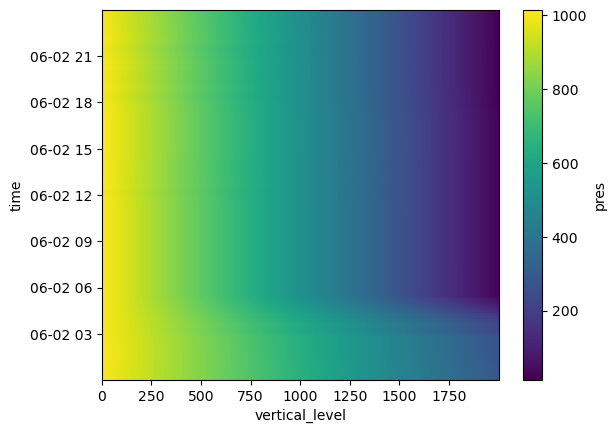

In [275]:
continental_sounding_dataset.pres.plot()